In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
raw = pd.read_csv('../jsons/very_clean_data.csv')

The second model that I will be fitting is a Naive Bayes classifier. A Naive Bayes classifier is even more computationally efficient than a Logistic Regression, and often is not swayed by irrelevant/noisy variables. One drawback to the model is that it relies on the "naive" assumption that all attributes are independent of one another, which often is not the case

It is one of the more widely adopted models for text class, in part because of its use as a SPAM filtering model.

In [7]:
tfidf = TfidfVectorizer(stop_words='english', min_df=3, max_df=1.0,max_features=12000, ngram_range=(1,4))

In [8]:
X = raw['text']
y = raw['target']

In [9]:
X = tfidf.fit_transform(X)

In [10]:
X = pd.SparseDataFrame(X, columns=tfidf.get_feature_names())
X.fillna(0,inplace=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [12]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
nb_predict = nb.predict(X_test)

In [14]:
nb_cv_score = cross_val_score(nb, X, y, cv=5, scoring='precision')

In [15]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, nb_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, nb_predict))
print('\n')
print("=== All Precision Scores ===")
print(nb_cv_score)
print('\n')
print("=== Mean Precision Score ===")
print("Mean Precision Score - Naive Bayes: ", nb_cv_score.mean())

=== Confusion Matrix ===
[[  620  5082]
 [  404 15089]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.61      0.11      0.18      5702
          1       0.75      0.97      0.85     15493

avg / total       0.71      0.74      0.67     21195



=== All Precision Scores ===
[0.74769914 0.74358335 0.74464142 0.74104768 0.74643147]


=== Mean Precision Score ===
Mean Precision Score - Naive Bayes:  0.7446806139386025


Let's see how the model's scores change as the confidence thresholds are adjusted

In [14]:
nb_probas = nb.predict_proba(X_test)

### With the thresholds applied

In [15]:
pred_proba_df = pd.DataFrame(nb_probas)

In [16]:
precision_scores = []
accuracy_scores = []
auc_roc_scores = []
avg_precision_scores = []
recall_scores = []
true_poses = []
false_poses = []

In [17]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

for i in threshold_list:
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    
    first_part = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    second_part = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);
    
    prec_score = precision_score(first_part, second_part)
    precision_scores.append(prec_score)
    pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    acc_score = accuracy_score(first_part,second_part)
    accuracy_scores.append(acc_score)
    
    aucroc_score = roc_auc_score(first_part,second_part)
    auc_roc_scores.append(aucroc_score)
    
    avg_prec_score = average_precision_score(first_part,second_part)
    avg_precision_scores.append(avg_prec_score)
    
    rec_score = recall_score(first_part,second_part)
    recall_scores.append(rec_score)
    
    true_pos = confusion_matrix(first_part,second_part)[1][1]
    true_poses.append(true_pos)
    
    false_pos = confusion_matrix(first_part,second_part)[0][1]
    false_poses.append(false_pos)

C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sy

In [18]:
all_scores = {'thresholds': threshold_list, 
        'precision_scores': precision_scores, 
        'accuracy_scores': accuracy_scores,
       'auc_roc_scores': auc_roc_scores,
       'avg_precision_scores': avg_precision_scores,
             'recall_scores': recall_scores,
             'true_positives': true_poses,
             'false_positives': false_poses}

In [19]:
all_scores = pd.DataFrame(all_scores)

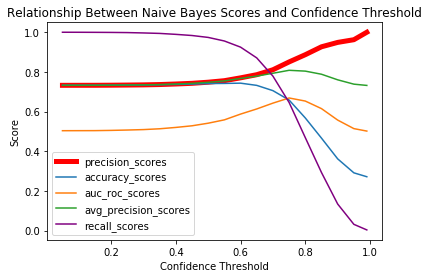

In [26]:
plt.plot('thresholds', 'precision_scores', data=all_scores, marker='', markerfacecolor='blue', markersize=10, color='red', linewidth=5)
plt.plot('thresholds', 'accuracy_scores', data=all_scores)
plt.plot('thresholds', 'auc_roc_scores', data=all_scores)
plt.plot('thresholds', 'avg_precision_scores', data=all_scores)
plt.plot('thresholds', 'recall_scores', data=all_scores,color='purple')
plt.title('Relationship Between Naive Bayes Scores and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')


plt.legend()

In [21]:
y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>.85 else 0)
test_accuracy = accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
print('Our testing accuracy is {}'.format(test_accuracy))
print('\n')
print('Confusion Matrix:')
print('\n')
print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))
print('\n')
print(classification_report(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))

Our testing accuracy is 0.4660061335220571


Confusion Matrix:


[[ 5343   359]
 [10959  4534]]


              precision    recall  f1-score   support

           0       0.33      0.94      0.49      5702
           1       0.93      0.29      0.44     15493

   micro avg       0.47      0.47      0.47     21195
   macro avg       0.63      0.61      0.47     21195
weighted avg       0.77      0.47      0.46     21195



C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\16313\Anaconda3\lib\

In [22]:
pred_probas = pd.DataFrame(nb_probas)
y_test_labels = pd.DataFrame(y_test).reset_index()
preds_merged = pd.concat([pred_probas,y_test_labels],axis=1).set_index('index')
preds_with_orig = pd.concat([preds_merged,raw],axis=1)
preds_with_orig = preds_with_orig.dropna()
preds_with_orig.reset_index(inplace=True)
preds_with_orig.columns = ['label','NB_0','NB_1','target','target2','text']

In [23]:
preds_with_orig.head()

,label,NB_0,NB_1,target,target2,text
0,2,0.000004,0.999996,1.0,1,Be Fun Fancy Free sort comment new thread Fun ...
1,8,0.108307,0.891693,1.0,1,As far I'm concerned Guillermo del Toro constr...
2,10,0.133968,0.866032,1.0,1,I writing essay I can't find word something lo...
3,14,0.631982,0.368018,1.0,1,Video Form Ah scary movie There something make...
4,15,0.256183,0.743817,1.0,1,Please use discus week's latest release We're ...


In [24]:
preds_with_orig[['label','NB_0','NB_1','target']].to_csv('../jsons/NB_probas.csv',index=False)

In [25]:
all_scores.to_csv('../jsons/NB_scores.csv')

In [27]:
nb.coef_

array([[-10.75802884, -10.24330506, -10.26813279, ...,  -9.09920981,
        -10.31830807, -10.43387823]])

In [28]:
coeffs = pd.DataFrame(nb.coef_).T
coeffs['word'] = pd.Series(X.columns).T

In [29]:
coeffs['word'] = pd.Series(X.columns).T

In [30]:
coeffs.sort_values(0,ascending=False).head(10)

,0,word
3674,-4.830855,film
6955,-5.101957,movie
6002,-5.364188,like
10656,-5.482147,think
8631,-5.706558,really
7822,-5.857286,people
10822,-5.867059,time
4446,-5.929062,good
4551,-6.035165,great
6439,-6.050457,make


7

The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model. For a binary classification problems this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features for the positive class.

The above print shows the top 20 lowest values (less predictive features) in the first column and the top 20 high values (highest predictive features) in the second column.

https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features

In [31]:
coeffs.sort_values(0,ascending=False).tail(20)

,0,word
1736,-12.36528,cmv post
2700,-12.36528,discussing television sub
11421,-12.36528,viewpoint hold movie
3920,-12.36528,film similarity discussing
3921,-12.36528,film similarity discussing television
10938,-12.36528,topic discussion lighter movie
10939,-12.36528,topic long
2701,-12.36528,discussing television sub use
10940,-12.36528,topic long comment
11422,-12.36528,viewpoint hold movie director
